In [13]:
%reset -f
import librosa as lb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Summary

**1 – Importing MNIST data**

**2 – Signal to mel spectrogram**

**3 – Min / max normalisation**

**4 – Splitting data**

**5 – Saving data**

# 1 – Importing MNIST data

We will use the [Audio MNIST](https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist) dataset available in Kaggle. It consists of 30000 audio samples of spoken digits (0-9). More precisely, we must deal with 60 folders. One folder corresponds to one person. This person is pronouncing each number 50 times. Then, each folder contains 500 files.

In [14]:
n_folders = 60
m = 50 #each person pronounces each number m times
list_signals, list_sr = [], [] #data (sr stands for sample rate)

for n in range(n_folders): #we go through each folder (<=> each person)  
    for digit in range(10): #we look at each digit
        for i in range(m):
            
            #building the path name (example : "MNIST/08/4_08_27.wav")
            n_str = str(n+1) #converting to string (the first folder is 01, not 0")
            if n < 9: #we need to add a "0" before
                n_str = "0" + n_str
            path = "MNIST/" + n_str + "/" + str(digit) + "_" + n_str + "_" + str(i) + ".wav"
            
            signal, sr = lb.load(path) #we extract the audio 
            list_signals.append(signal)
            list_sr.append(sr)

In [15]:
n_data = len(list_signals)
print("number of data (expected 30'000) :", n_data)

print("list of sample rates : ", set(list_sr))
sr = list_sr[0]

size_signals = [len(signal) for signal in list_signals]
print("size of the signals : from", min(size_signals), "to", max(size_signals))
print("=>", round(min(size_signals)/sr, 3), "second to", round(max(size_signals)/sr, 3), "second")
#each audio doesn't surpass 1 second (sr=22050 samples)

number of data (expected 30'000) : 30000
list of sample rates :  {22050}
size of the signals : from 6465 to 22050
=> 0.293 second to 1.0 second


# 2 – Signal to mel spectrogram

Here, we transform signals to **mel spectrograms**. They represent sounds with a frequency scale that more closely resembles how humans perceive pitch. We set the dimensions (*width*, *height*) of each mel spectrogram.

In [16]:
width = 50
height = 50

hop_length = int((sr+1) / width) + 1 #parameter of the transformation
x = np.zeros((n_data, width, height)) #input data that will contain mel spectrograms

for i in range(n_data):
    signal = np.zeros(sr)
    signal[:len(list_signals[i])] = np.array(list_signals[i])
    #if the sound duration is less than 1 second, we add 0s at the end
    
    S = lb.feature.melspectrogram(y=signal, sr=sr, hop_length=hop_length, n_mels=height)
    S = lb.power_to_db(S)
    x[i, :, :] = S

Now, let's look at a random mel spectrogram.

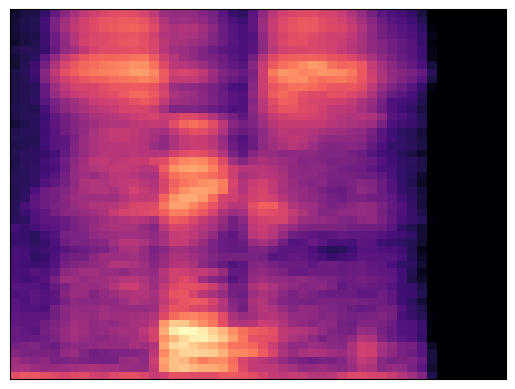

In [17]:
random_index = np.random.randint(n_data)
lb.display.specshow(x[random_index])

# 3 – Min / max normalisation

In [18]:
min_values = np.min(x, axis=0)
max_values = np.max(x, axis=0)
x = (x-min_values) / (max_values-min_values) #each coefficient is between 0 and 1

# 4 – Splitting data

Here, we mustn't shuffle the data. Otherwise, some people will appear in both datasets. We want the model to handle voices it has never heard before.

In [19]:
x_train = x[:int(0.75*n_data)] #75% train
x_test = x[int(0.75*n_data):] #25% test

# 5 – Saving data

Finally, we save data in the *data* folder.

In [20]:
np.save("data/x_train", x_train)
np.save("data/x_test", x_test)
np.save("data/min_values", min_values)
np.save("data/max_values", max_values)